<a href="https://colab.research.google.com/github/ssrbazpur/Data-Science/blob/master/Using_BQML_to_make_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using BQML to Predict Demand for NYC Taxis based on the Weather Forecast

Goal is to build a predictive model using only BigQuery standard SQL. Since this is a Python notebook, we'll use some of the features of Python to analyze the data (ie. a loss function for calculating RSME), but the model itself and it's preditive comes comes from BigQuery alone. This is called BigQuery ML (BQML) and we couldn't be more excited to try it out!

To get started, we'll take a [classic Machine Learning example](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/CPB100/lab4a/demandforecast.ipynb) and remove the TensorFlow piece. Rest assured, TensorFlow is still being used, but it has been abstracted from view. You'll notice this model performs significantly better than the predessor, and it do this with no customatization on the model.


In [0]:
import pandas as pd
import numpy as np
import sys
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/NYC Taxi-eb10197ea31e.json"
%reload_ext google.cloud.bigquery

You'll need to define some variables that will be used throughout the notebook. These are the GCP `project_id`, the `model_name` can be any name you prefer, and finally the `dateset_name`. The dataset needs to exist in the same project as the `project_id` and you need to have sufficient access to create and delete.

In [0]:
#@title Setup Project Variables { run: "auto", display-mode: "form" }
project_id = 'nyc-taxi-265120' #@param {type:"string"}
dataset_name = "Taxitemp" #@param {type:"string"}
model_name = "pats_taxi_model" #@param {type:"string"}
eval_name = model_name + "_eval"
client = bigquery.Client(project=project_id)

## Create a Linear Regression Model

In [0]:

project_id = 'nyc-taxi-265120' #@param{type:"string"}
from google.cloud import bigquery
#from google.cloud import bigquery_storage_v1beta1
# Create BigQuery client
client = bigquery.Client(project = project_id)
# Create BigQuery storage client
#bq_storage_client = bigquery_storage_v1beta1.BigQueryStorageClient()

### Creating labeled data
This query can be run in BigQuery on its own. Try it out! This query gives us 3 years of taxi and weather data for the NYC region. Those two datasets represent our labeled data: weather as our features (or metrics) and taxi trips as our label (target, class, objective, etc...).

In [0]:
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2019`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(
WITH AB AS
(
SELECT  CAST(tpep_pickup_datetime AS DATETIME) AS PICKUP,* FROM `nyc-taxi-265120.NYC.2019_CreatedDataset`
)  
SELECT  PICKUP,CAST(EXTRACT (YEAR from PICKUP) AS STRING) AS year,EXTRACT (DAYOFYEAR from PICKUP) AS daynumber,EXTRACT (HOUR from PICKUP) AS hour, cast(PULocationID as STRING) as LOCATION,COUNT(1) AS numtrips FROM AB group by PICKUP,year,daynumber,hour,LOCATION),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)


SELECT cast(wd.dayofweek as STRING) as dayofweek, 
    wd.mintemp, 
    wd.maxtemp,
    wd.rain,
    td.numtrips  as label,
    td.hour,
    
    ST_ASTEXT(points.p) AS P,
    td.daynumber,
    points.zone_name,
    
  FROM wd, td INNER JOIN points ON points.zone_id=td.LOCATION
  where wd.year = td.year AND
  wd.daynumber = td.daynumber AND
  eXTRACT (YEAR from PICKUP) =2019
  group by daynumber,zone_name,P,dayofweek,hour, mintemp, maxtemp, rain, numtrips
  
  
   
  
 

"""
df = client.query(query).to_dataframe()


In [181]:
df.head()

,dayofweek,mintemp,maxtemp,rain,label,hour,P,daynumber,zone_name
0,2,6.1,19.9,0.20,1,6,POINT(-73.9841965572521 40.7598175648545),21,Times Sq/Theatre District
1,2,6.1,19.9,0.20,1,15,POINT(-73.9904579139814 40.7403373707504),21,Union Sq
2,1,19.9,39.9,1.14,1,17,POINT(-73.9784915842276 40.7477457301956),20,Murray Hill
3,2,6.1,19.9,0.20,1,11,POINT(-73.9723561596285 40.7566875349726),21,Midtown East
4,1,19.9,39.9,1.14,1,17,POINT(-73.9775685681851 40.7644214378895),20,Midtown North


In [182]:
print df.shape

(796875, 9)


In [0]:
df.drop('P', axis=1, inplace=True)

In [0]:
df.head()

,dayofweek,mintemp,maxtemp,rain,label,hour,PICKUP,daynumber,zone_name
0,1,55.9,75.0,0.28,1,20,2019-04-14 20:57:24,104,Penn Station/Madison Sq West
1,1,55.9,75.0,0.28,1,22,2019-04-14 22:01:24,104,Stuy Town/Peter Cooper Village
2,1,55.9,75.0,0.28,2,21,2019-04-14 21:08:42,104,East Village
3,1,55.9,75.0,0.28,1,13,2019-04-14 13:26:20,104,Hudson Sq
4,1,55.9,75.0,0.28,1,19,2019-04-14 19:22:44,104,Greenwich Village North


In [0]:
df['just_date'] = df['PICKUP'].dt.date

In [0]:
df.drop('PICKUP', axis=1, inplace=True)

In [12]:
df.head()

,dayofweek,mintemp,maxtemp,rain,label,hour,daynumber,zone_name,just_date
0,1,55.9,75.0,0.28,1,20,104,Penn Station/Madison Sq West,2019-04-14
1,1,55.9,75.0,0.28,1,22,104,Stuy Town/Peter Cooper Village,2019-04-14
2,1,55.9,75.0,0.28,2,21,104,East Village,2019-04-14
3,1,55.9,75.0,0.28,1,13,104,Hudson Sq,2019-04-14
4,1,55.9,75.0,0.28,1,19,104,Greenwich Village North,2019-04-14


In [0]:
import datetime
d = datetime.date(2015, 2, 20)
print d.day

20


In [0]:
df.head()

""


In [184]:
df.isnull().sum()

dayofweek    0
mintemp      0
maxtemp      0
rain         0
label        0
hour         0
daynumber    0
zone_name    0
dtype: int64

In [0]:
df.drop('just_date', axis=1, inplace=True)

In [0]:
rated_dummies = pd.get_dummies(imdb_movies.Rated)
pd.concat([imdb_movies, rated_dummies], axis=1)

In [0]:
rated_dummies=pd.get_dummies(df['zone_name'])

In [0]:
df=pd.concat([df, rated_dummies], axis=1)

In [0]:
df.drop('zone_name', axis=1, inplace=True)

In [189]:
df.shape

(796875, 265)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 142 entries, dayofweek to Yorkville West
dtypes: float64(3), int64(3), object(1), uint8(135)
memory usage: 1.8+ MB


In [0]:
df["dayofweek"] = df["dayofweek"].astype(int)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796875 entries, 0 to 796874
Columns: 265 entries, dayofweek to Yorkville West
dtypes: float64(3), int64(4), uint8(258)
memory usage: 238.6 MB


In [0]:
train=df

In [169]:
train.head()

,dayofweek,mintemp,maxtemp,rain,label,hour,daynumber,Allerton/Pelham Gardens,Alphabet City,Arden Heights,Arrochar/Fort Wadsworth,Astoria,Astoria Park,Auburndale,Baisley Park,Bath Beach,Battery Park,Battery Park City,Bay Ridge,Bay Terrace/Fort Totten,Bayside,Bedford,Bedford Park,Bellerose,Belmont,Bensonhurst East,Bensonhurst West,Bloomfield/Emerson Hill,Bloomingdale,Boerum Hill,Borough Park,Breezy Point/Fort Tilden/Riis Beach,Briarwood/Jamaica Hills,Brighton Beach,Bronx Park,Bronxdale,Brooklyn Heights,Brooklyn Navy Yard,Brownsville,Bushwick North,...,Steinway,Stuy Town/Peter Cooper Village,Stuyvesant Heights,Sunnyside,Sunset Park East,Sunset Park West,Sutton Place/Turtle Bay North,Times Sq/Theatre District,TriBeCa/Civic Center,Two Bridges/Seward Park,UN/Turtle Bay South,Union Sq,University Heights/Morris Heights,Upper East Side North,Upper East Side South,Upper West Side North,Upper West Side South,Van Cortlandt Park,Van Cortlandt Village,Van Nest/Morris Park,Washington Heights North,Washington Heights South,West Chelsea/Hudson Yards,West Concourse,West Farms/Bronx River,West Village,Westchester Village/Unionport,Westerleigh,Whitestone,Willets Point,Williamsbridge/Olinville,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodlawn/Wakefield,Woodside,World Trade Center,Yorkville East,Yorkville West
0,3,35.1,60.1,1.39,2,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,35.1,60.1,1.39,1,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,35.1,60.1,1.39,1,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,35.1,60.1,1.39,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,35.1,60.1,1.39,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train=train.drop('label', axis=1)

In [171]:
df.head()

,dayofweek,mintemp,maxtemp,rain,label,hour,daynumber,Allerton/Pelham Gardens,Alphabet City,Arden Heights,Arrochar/Fort Wadsworth,Astoria,Astoria Park,Auburndale,Baisley Park,Bath Beach,Battery Park,Battery Park City,Bay Ridge,Bay Terrace/Fort Totten,Bayside,Bedford,Bedford Park,Bellerose,Belmont,Bensonhurst East,Bensonhurst West,Bloomfield/Emerson Hill,Bloomingdale,Boerum Hill,Borough Park,Breezy Point/Fort Tilden/Riis Beach,Briarwood/Jamaica Hills,Brighton Beach,Bronx Park,Bronxdale,Brooklyn Heights,Brooklyn Navy Yard,Brownsville,Bushwick North,...,Steinway,Stuy Town/Peter Cooper Village,Stuyvesant Heights,Sunnyside,Sunset Park East,Sunset Park West,Sutton Place/Turtle Bay North,Times Sq/Theatre District,TriBeCa/Civic Center,Two Bridges/Seward Park,UN/Turtle Bay South,Union Sq,University Heights/Morris Heights,Upper East Side North,Upper East Side South,Upper West Side North,Upper West Side South,Van Cortlandt Park,Van Cortlandt Village,Van Nest/Morris Park,Washington Heights North,Washington Heights South,West Chelsea/Hudson Yards,West Concourse,West Farms/Bronx River,West Village,Westchester Village/Unionport,Westerleigh,Whitestone,Willets Point,Williamsbridge/Olinville,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodlawn/Wakefield,Woodside,World Trade Center,Yorkville East,Yorkville West
0,3,35.1,60.1,1.39,2,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,35.1,60.1,1.39,1,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,35.1,60.1,1.39,1,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,35.1,60.1,1.39,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,35.1,60.1,1.39,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
y=df['label']
X=train

In [0]:
close_price=df.filter(["label"])

In [96]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_values=scaler.fit_transform(close_price)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [145]:
y.shape

(10000,)

In [110]:
np.reshape(a, (2, 3))

10000

In [0]:
from sklearn.preprocessing import RobustScaler
rbX = RobustScaler()
X1 = rbX.fit_transform(X)

rbY = RobustScaler()
Y1 = rbY.fit_transform(y)

In [0]:
b=np.reshape(scaled_values, (len(scaled_values), ))

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [196]:
y_train.shape

(597656,)

In [197]:
max(y)

45

TypeError: ignored

In [0]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [0]:
xgboost = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)

In [0]:
y_test

In [0]:
xgb_prediction = xgboost.predict(X_test)


In [179]:

max(xgb_prediction)

3

In [206]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
import pickle


pkl_filename = "/content/drive/My Drive/Data Science/pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logreg, file)

In [0]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    


In [0]:
a=X_test.iloc[0]

In [221]:
type(a)

pandas.core.series.Series

In [0]:
a=a.to_numpy()

In [236]:
a.shape

(264,)

In [0]:
a = a.reshape((1, 264))

In [239]:
a.shape

(1, 264)

In [258]:
b=X_test.iloc[:0]
b

,dayofweek,mintemp,maxtemp,rain,hour,daynumber,Allerton/Pelham Gardens,Alphabet City,Arden Heights,Arrochar/Fort Wadsworth,Astoria,Astoria Park,Auburndale,Baisley Park,Bath Beach,Battery Park,Battery Park City,Bay Ridge,Bay Terrace/Fort Totten,Bayside,Bedford,Bedford Park,Bellerose,Belmont,Bensonhurst East,Bensonhurst West,Bloomfield/Emerson Hill,Bloomingdale,Boerum Hill,Borough Park,Breezy Point/Fort Tilden/Riis Beach,Briarwood/Jamaica Hills,Brighton Beach,Broad Channel,Bronx Park,Bronxdale,Brooklyn Heights,Brooklyn Navy Yard,Brownsville,Bushwick North,...,Stuy Town/Peter Cooper Village,Stuyvesant Heights,Sunnyside,Sunset Park East,Sunset Park West,Sutton Place/Turtle Bay North,Times Sq/Theatre District,TriBeCa/Civic Center,Two Bridges/Seward Park,UN/Turtle Bay South,Union Sq,University Heights/Morris Heights,Upper East Side North,Upper East Side South,Upper West Side North,Upper West Side South,Van Cortlandt Park,Van Cortlandt Village,Van Nest/Morris Park,Washington Heights North,Washington Heights South,West Brighton,West Chelsea/Hudson Yards,West Concourse,West Farms/Bronx River,West Village,Westchester Village/Unionport,Westerleigh,Whitestone,Willets Point,Williamsbridge/Olinville,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodlawn/Wakefield,Woodside,World Trade Center,Yorkville East,Yorkville West


In [259]:
from pandas import DataFrame as df  
mydf = df(a).T  
b.loc[len(b)] = a  
print(b)

   dayofweek  mintemp  ...  Yorkville East  Yorkville West
0        3.0     34.0  ...             0.0             1.0

[1 rows x 264 columns]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [260]:

logreg_prediction = pickle_model.predict(b)
print logreg_prediction

[2]


In [210]:
logreg_prediction = pickle_model.predict(X_test)
logreg_score=accuracy_score(y_test, logreg_prediction)
print(logreg_score)

0.7318378267133155


### Data Exploration

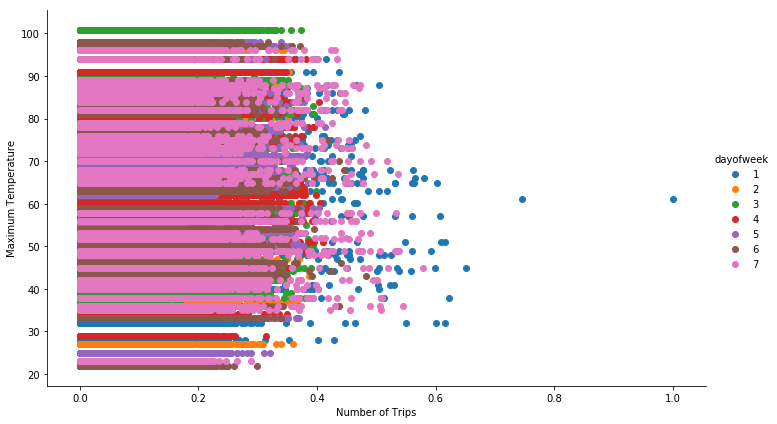

In [0]:
import seaborn
from  matplotlib import pyplot as plt
fg = seaborn.FacetGrid(data=data, hue='dayofweek', height=6,aspect=1.67)
fg = fg.map(plt.scatter, 'label', 'maxtemp').add_legend()
fg = fg.set_axis_labels(x_var="Number of Trips", y_var="Maximum Temperature")

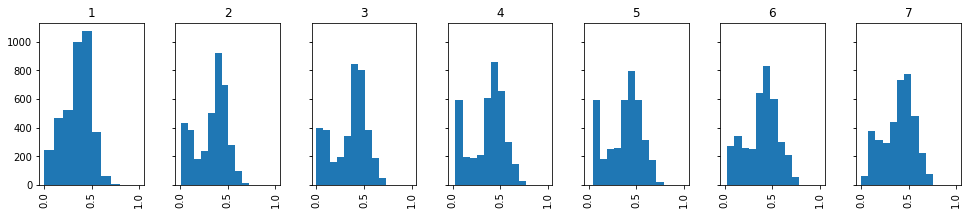

In [0]:
_ = data.hist(column='label',by='dayofweek', layout=(1,7), figsize=(16,3), sharey=True, sharex=True)

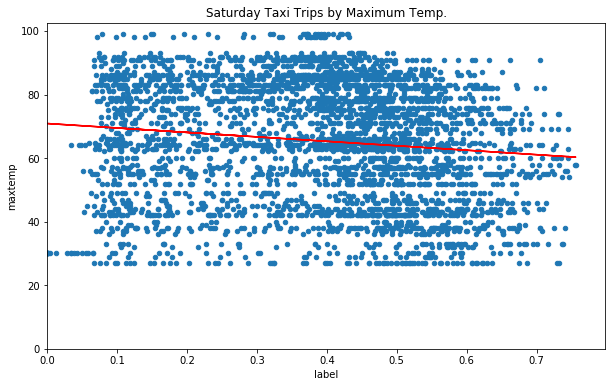

In [0]:
df = data[data.dayofweek == '7']
x = df.label
y = df.maxtemp
df.plot(kind="scatter",x="label",y="maxtemp", figsize=[10,6],ylim=0,xlim=0)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r")
plt.title("Saturday Taxi Trips by Maximum Temp.")
plt.show()

We see that trips made on a Saturday have a strong correlation with the maximum temperature. As the temperature descreases the demand for taxis increases. Our model is likely going to be able to use the predictive power found within this relationship between feature inputs and our target variable.

### Defining Model Parameters

In order to turn the above SQL into a predictive model, we simply need to `CREATE` the `MODEL` specifiying `linear_reg` or `logistic_reg`. This lets you build models for both regression (continous variable prediction) or classification (discreet variable prediction). Refer to the BQML documentation for more information on options and configuring your predictive model.

In [0]:
query = """
  CREATE OR REPLACE MODEL {0}.{1} 
    OPTIONS (
      model_type='linear_reg'
    ) as {2}
""".format(dataset_name, model_name, taxidemand)

### `CREATE MODEL` using `linear_reg`
The `for` loop will kick-off the `query_job` that has the `query` waiting to be processed. Once the job finishes it will continue through the `query_job` iterator until finished. At this point in time, the Google Cloud Python BigQuery API is throwing errors; these will be addressed in the near future.

In [0]:
query_job = client.query(query)
dataset_ref = client.dataset(dataset_name)
try: 
  for row in query_job:
    print row
except:
  print "ignoring this error: {}".format(sys.exc_info()) #  the model was successfully created

# confirm new tables exist in dataset
for i in client.list_tables(dataset_ref):
  if (i.table_id == model_name or i.table_id == eval_name):
     print i.table_id

pats_taxi_model


## Get `ml.EVALUATE()` info

### Baseline Mean Absolute Error
We want to establish a baseline to measure ourselves against. Below, we take the entire dataset (using the `taxidemand` query). Taking the mean of `numtrips` gives us an average daily trip count of `403,642`.  We'll use Pandas Mean Absolute Deviation function to calculate our MAE.

In [0]:
# Our prediction should beat the average MAE
df = client.query(taxidemand).to_dataframe()
print 'Average trips={0} with a MAE of {1}'.format(
    int(df.label.mean()*maxtrips), # scale value using the maxtrips variable
    int(df.label.mad()*maxtrips) # MAE, MAD = Mean Absolute Error, Mean Absolute Difference
)

Average trips=107 with a MAE of 129


### `ml.EVALUATE()`
We're looking to beat the MAE (shown below as `mean_absolute_error`)  of `50,419`. Fingers crossed!

In [0]:
query = ("select * from ml.EVALUATE(MODEL {0}.{1}, ({2}))") \
  .format(dataset_name, model_name, taxidemand)
df = client.query(query).to_dataframe()
df["mean_absolute_error"] = np.multiply(df["mean_absolute_error"],maxtrips).astype(int)
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,62,0.000979,0.000794,0.011059,0.669556,0.669556


Smashed it!

### Custom Loss Function
Do you read the articles that include "the hard way" in them? Perhaps you like to to see the math in action. Below we create a custom loss function and evaluate it against our model. We'll do this using the entire dataset (as defined by `taxidemand`).  We'd expect our `model_MAE` to match the `mean_absolute_error` value returned by the `ml.EVALUATE` function above.  Fingers crossed!

In [0]:
query = """
SELECT SUM(error) / COUNT(*) as model_MAE from (
  SELECT  abs(predicted_label-label) as error
          FROM ML.PREDICT(MODEL `{0}.{1}` , ({2}))
)
""".format(dataset_name, model_name, taxidemand)
df = client.query(query).to_dataframe()
print int(df.model_MAE*maxtrips)

4579


Sure enough, the math adds up!

## Get `ml.TRAINING_INFO()` for the model
This shows us how many training procedures were needed to reach convergence, and provides various metrics associated with the training run. The system performs hyperparameter tuning automatically in order to establish the best model settings.

In [0]:
query = "select * from ml.TRAINING_INFO(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.000979,0.00098,None,14871


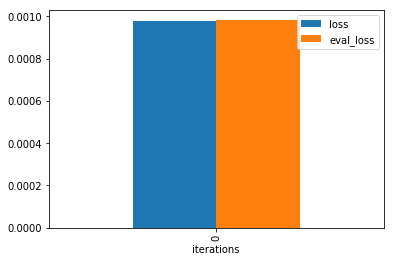

In [0]:
_ = df[['loss','eval_loss']].plot(kind='bar').set_xlabel('iterations')

## Get ml.FEATURE_INFO() for the model
This function prints out the descriptive statistics for the numerical features: min(), max(), avg(), and standard deviation. The category count shows the number of distinct values found within a categorical feature. Null count is important to note because the model will automatically convert nulls to the mean of the feature set (fairly standard practice, but could be controversial!)

In [0]:
query = "select * from ml.FEATURE_INFO(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df

,input,min,max,mean,median,stddev,category_count,null_count
0,dayofweek,NaN,NaN,NaN,NaN,NaN,7.0,NaN
1,mintemp,12.0,80.10,49.681762,51.1,15.973619,NaN,0.0
2,maxtemp,21.9,100.90,67.128720,69.1,17.223547,NaN,0.0
3,rain,0.0,2.79,0.120547,0.0,0.326036,NaN,0.0
4,hour,0.0,23.00,11.593986,12.0,6.947616,NaN,0.0
5,pickup_location_id,NaN,NaN,NaN,NaN,NaN,265.0,NaN


## Get `ml.WEIGHTS()` for the `dayofweek`
We created a linear model, here are the weights applied to the features of that model.

In [0]:
query = "select * from ml.WEIGHTS(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
pd.DataFrame({ 
    "processed_input" : df.processed_input,
    "weights": df.weight 
})

,processed_input,weights
0,dayofweek,NaN
1,mintemp,-0.000120
2,maxtemp,0.000062
3,rain,-0.000455
4,hour,0.001457
5,pickup_location_id,NaN
6,__INTERCEPT__,42371.930773


In [0]:
query = "select * from ml.WEIGHTS(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df = pd.DataFrame(df.category_weights[0]).sort_values(by='category')
df.round(2)

,category,weight
2,1,-0.0
4,2,-0.0
5,3,-0.0
6,4,0.0
1,5,0.0
3,6,0.0
0,7,0.0


## Make Predictions
Adjust the sliders to create new input values to be evaluated by the model.  The model takes the min and max tempertatures plus rainfall for any given day of the week and returns the predicted number of taxi trips that will occur that day. 

In [0]:
#@title Select your input parameters { run: "auto", display-mode: "form" }
mintemp = 29 #@param {type:"slider", min:1, max:90, step:1}
maxtemp = 67 #@param {type:"slider", min:10, max:110, step:1}
rain = 3.6 #@param {type:"slider", min:0, max:5, step:0.1}
dayofweek = 4 #@param {type:"slider", min:1, max:7, step:1}
hour = 7 #@param {type:"slider", min:0, max:24, step:1}


query = """
  select *
  from ml.PREDICT(
    MODEL {0}.{1},  (
      select  '{5}' as dayofweek,  
              {2} as mintemp,  
              {3} as maxtemp, 
              {4} as rain
    )
  )
""".format(dataset_name, 
           model_name, 
           mintemp,
           maxtemp,
           rain,
           dayofweek)

df = client.query(query).to_dataframe()
df["predicted_label"] = np.multiply(df["predicted_label"],maxtrips).astype(int)
df

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: ignored